<ipython-input-2-4b6010b42126>:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right',fontsize=10)


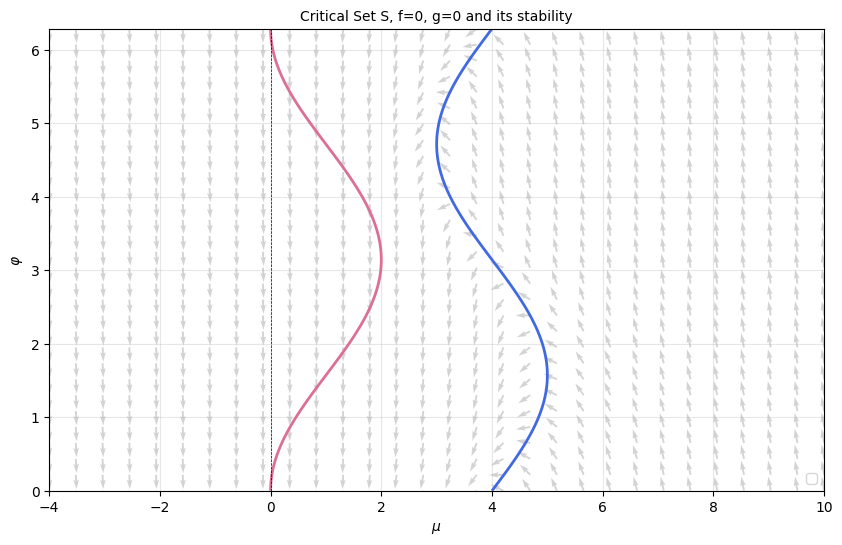

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from plotly.subplots import make_subplots
from scipy.optimize import fsolve
from matplotlib import pyplot

#Set of parameters
eta=1
alpha=np.pi/2
omega=-4
epsilon=0.1

def f(mu, phi):
    """
    This is a function corresponding to the derivative with respect to the fast time t of phi, the phase of the neuron.
    Vars:
        mu: float
        phi: float
    """
    return omega+mu-np.sin(phi)

def g(mu, phi):
    """
    This is a function corresponding to the derivative with respect to the fast time t of mu, which is a slowly varying adaptive input
    Vars:
        mu: float
        phi: float
    """
    return epsilon*(-mu+eta*(1-np.sin(phi+alpha)))


def equations(vars):
    mu, phi = vars
    return [f(mu, phi), g(mu, phi)]

def jacobian(mu, phi):
    """
    This is a function corresponding to the Jacobian matrix of the equations of the theta-neuron model
    Vars:
        mu: float
        phi: float
    """
    dg_dmu=-epsilon
    dg_dphi=-epsilon*eta*np.cos(phi+alpha)
    df_dmu=1
    df_dphi=-np.cos(phi)
    J=np.array([[dg_dmu, dg_dphi],
                  [df_dmu, df_dphi]])
    return J


#Grid of initial guesses in order to find equilibria
phi_initial_guesses = np.linspace(0, 2*np.pi, 10)  #10 evenly spaced values of initial guesses for phi that range from 0 to 2*pi
mu_initial_guesses = np.linspace(-2, 2, 10) #10 evenly spaced values of initial guesses for mu that rnage from -2 to 2
initial_guesses = [(mu_guess, phi_guess) for mu_guess in mu_initial_guesses for phi_guess in phi_initial_guesses] #Cartesian product of the two arrays

#Here it calculates the intersection points of f and g which will correspond to the coortdinates of phi and mu of the equilibrium points
#The solution is also validated and also we asses if it is unique or not
eq_points = []
for initial_guess in initial_guesses:
    sol, info, ier, mesg = fsolve(
        equations, initial_guess, full_output=True, xtol=1e-12, maxfev=1000
    )
    mu_sol, phi_sol=sol
    phi_sol=phi_sol%(2 * np.pi)
    f_val, g_val=equations(sol)
    is_new = True
    for mu_exist, phi_exist in eq_points:
        if np.isclose(mu_sol, mu_exist, atol=1e-6) and np.isclose(phi_sol, phi_exist, atol=1e-6):
            is_new = False
            break
    if is_new and np.allclose([f_val, g_val], [0, 0], atol=1e-6):
        eq_points.append((mu_sol, phi_sol))

equilibria=[]

#Here the solutions of phi and mu from the previous section will be used in order to assess their stability and classify the points as either stable or unstable
for mu_sol, phi_sol in eq_points:
    J=jacobian(mu_sol, phi_sol)
    eigenvalues=np.linalg.eigvals(J)
    real_parts=np.real(eigenvalues)
    print(f"Equilibrium at mu={mu_sol:.6f}, phi={phi_sol:.6f}")
    print(f"Eigenvalues: {eigenvalues}")
    if np.all(real_parts<0):
        stability = 'Stable'
    else:
        stability = 'Unstable'
    print(f"Classified as: {stability}\n")
    equilibria.append({'mu': mu_sol, 'phi': phi_sol, 'stability': stability})

stable_eq = {'mu': [], 'phi': []}
unstable_eq = {'mu': [], 'phi': []}

for eq in equilibria:
    if eq['stability'] == 'Stable':
        stable_eq['mu'].append(eq['mu'])
        stable_eq['phi'].append(eq['phi'])
    else:
        unstable_eq['mu'].append(eq['mu'])
        unstable_eq['phi'].append(eq['phi'])

#Here we are defining a grid for mu and phi and normalizing it
mu_vals=np.linspace(-4, 10, 30) #Here we are creating 30 evenly spaced values for mu_vals in between -2 and 2
phi_vals=np.linspace(0, 2*np.pi, 30) #Here we are creating 30 evenly spaced values for phi_vals in between 0 and 2*pi
phi, mu=np.meshgrid(phi_vals, mu_vals)
f_vals=f(mu, phi)
g_vals=g(mu, phi)

magnitude=np.sqrt(f_vals**2 + g_vals**2)
f_vals_normalized=f_vals/magnitude
g_vals_normalized=g_vals/magnitude

mu_fine=np.linspace(-4, 10, 500)
phi_fine=np.linspace(0, 2*np.pi, 500)
mu_fine,phi_fine=np.meshgrid(mu_fine, phi_fine)
f_fine=f(mu_fine, phi_fine)
g_fine=g(mu_fine, phi_fine)

#Here we are plotting the equilibria and the critical sets
plt.figure(figsize=(10, 6))

plt.contour(mu_fine, phi_fine, f_fine, levels=[0], colors='royalblue', linewidths=2)
plt.contour(mu_fine, phi_fine, g_fine, levels=[0], colors='palevioletred', linewidths=2)
plt.quiver(mu, phi, g_vals_normalized, f_vals_normalized, color='darkgrey', alpha=0.5) #Plotting the vector space

if stable_eq['mu']:
    plt.scatter(stable_eq['mu'], stable_eq['phi'], marker='^', s=100, color='forestgreen', label='Stable Equilibrium')
if unstable_eq['mu']:
    plt.scatter(unstable_eq['mu'], unstable_eq['phi'], marker='s', s=100, color='red', label='Unstable Equilibrium')

plt.title('Critical Set S, f=0, g=0 and its stability', fontsize=10)
plt.xlabel(r'$\mu$', fontsize=10)
plt.ylabel(r'$\varphi$', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend(loc='lower right',fontsize=10)
plt.show()
